In [ ]:
pip install requests

이미지가 성공적으로 저장되었습니다.


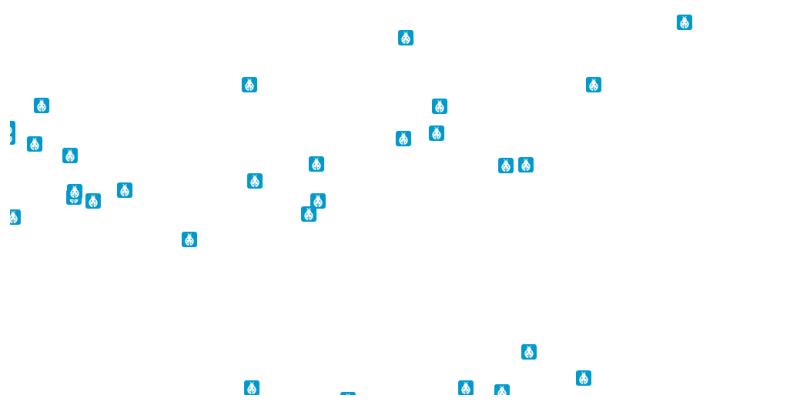

In [ ]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# API 요청 URL 설정
wms_url = "https://www.nie-ecobank.kr/ecoapi/NteeInfoService/wms/getInsectPointWMS"
service_key = 'VG79XS44P49090D5K2GMNM43TX25MS049BKLYS60'  # 실제 서비스 키로 대체하세요.

# Query parameters 설정
params = {
    'serviceKey': service_key,
    'srs': 'EPSG:5186',
    'width': '1000',
    'height': '500',
    'bbox': '314540.9311225004,400742.29949240043,320869.0145135768,419072.0397406582'
}

# GET 요청 보내기
response = requests.get(wms_url, params=params)

# 응답 확인 및 이미지 저장
if response.status_code == 200:
    content_type = response.headers['Content-Type']
    if 'image' in content_type:
        try:
            # 이미지 파일로 저장
            img = Image.open(BytesIO(response.content))
            img.save("insect_points_map.png")
            print("이미지가 성공적으로 저장되었습니다.")

            # 이미지 시각화
            plt.figure(figsize=(10, 5))
            plt.imshow(img)
            plt.axis('off')
            plt.show()

        except IOError:
            print("이미지를 열 수 없습니다.")
    else:
        print("응답이 이미지가 아닙니다. 응답 내용:")
        print(response.content.decode('utf-8'))
else:
    print(f"Request failed with status code {response.status_code}")


In [ ]:
import requests

# API 요청 URL 설정
wfs_url = "https://www.nie-ecobank.kr/ecoapi/NteeInfoService/wfs/getInsectPointWFS"
service_key = 'VG79XS44P49090D5K2GMNM43TX25MS049BKLYS60'  # 실제 서비스 키로 대체하세요.

# Query parameters 설정
params = {
    'serviceKey': service_key,
    'typeName': 'vw_map_ntee_insect_point',
    'bbox': '314540.9311225004,400742.29949240043,320869.0145135768,419072.0397406582',
    'srsName': 'EPSG:5186',
    'maxFeatures': '500',  # 원하는 최대 피처 수 설정
    'outputFormat': 'application/json'
}

# GET 요청 보내기
response = requests.get(wfs_url, params=params)

# 응답 확인 및 JSON 데이터 처리
if response.status_code == 200:
    data = response.json()
    features = data.get('features', [])

    # 각 피처의 좌표와 속성 출력
    for feature in features:
        geometry = feature.get('geometry', {})
        properties = feature.get('properties', {})

        coordinates = geometry.get('coordinates', [])
        insect_name = properties.get('spcs_korean_nm', 'Unknown')

        print(f"Insect: {insect_name}, Coordinates: {coordinates}")
else:
    print(f"Request failed with status code {response.status_code}")
    print(response.text)


Insect: 모메뚜기, Coordinates: [318806.63159999996, 402768.8314999994]
Insect: 우리귀매미, Coordinates: [318806.63159999996, 402768.8314999994]
Insect: 우리가시허리노린재, Coordinates: [318806.63159999996, 402768.8314999994]
Insect: 희미무늬알노린재, Coordinates: [318806.63159999996, 402768.8314999994]
Insect: 탈장님노린재, Coordinates: [318806.63159999996, 402768.8314999994]
Insect: 각시장님노린재, Coordinates: [319195.92789999954, 401523.03559999913]
Insect: 쑥다리장님노린재, Coordinates: [319195.92789999954, 401523.03559999913]
Insect: 넓은각시매미충, Coordinates: [319195.92789999954, 401523.03559999913]
Insect: 변색장님노린재, Coordinates: [319195.92789999954, 401523.03559999913]
Insect: 톱다리개미허리노린재, Coordinates: [319195.92789999954, 401523.03559999913]
Insect: 양봉꿀벌, Coordinates: [319195.92789999954, 401523.03559999913]
Insect: 애긴노린재, Coordinates: [319195.92789999954, 401523.03559999913]
Insect: 일본멸구, Coordinates: [319195.92789999954, 401523.03559999913]
Insect: 삿포로잡초노린재, Coordinates: [319195.92789999954, 401523.03559999913]
Insect: 메추리노린재, C

In [ ]:
import requests
import time
import folium
from pyproj import Proj, transform

# EPSG:5186 투영법 정의 (중부원점)
proj_5186 = Proj(init='epsg:5186')
# WGS84 투영법 정의 (위도/경도)
proj_wgs84 = Proj(init='epsg:4326')

# 서울 대략적인 좌표 (WGS84)
wgs84_bbox = [(126.7644, 37.4133), (127.1853, 37.7151)]

# 좌표 변환
min_x, min_y = transform(proj_wgs84, proj_5186, wgs84_bbox[0][0], wgs84_bbox[0][1])
max_x, max_y = transform(proj_wgs84, proj_5186, wgs84_bbox[1][0], wgs84_bbox[1][1])

bbox = f"{min_x},{min_y},{max_x},{max_y}"

params = {
    'serviceKey': service_key,
    'typeName': 'vw_map_ntee_insect_point',
    'bbox': bbox,
    'srsName': 'EPSG:5186',
    'outputFormat': 'application/json',
    'maxFeatures': '100'  # 한 번에 가져올 최대 피처 수
}


all_features = []
start_index = 0
while True:
    params['startIndex'] = start_index
    response = requests.get(wfs_url, params=params)

    if response.status_code == 200:
        data = response.json()
        features = data.get('features', [])

        if not features:
            # 더 이상 가져올 데이터가 없으면 종료
            break

        all_features.extend(features)
        start_index += len(features)

        # 서버에 부하를 주지 않도록 약간의 지연
        time.sleep(1)
    else:
        print(f"Request failed with status code {response.status_code}")
        print(response.text)
        break

print(f"총 피처 수: {len(all_features)}")

# 꿀벌 데이터 필터링
bee_features = [feature for feature in all_features if '꿀벌' in feature['properties'].get('spcs_korean_nm', '')]

bee_coordinates = [feature['geometry']['coordinates'] for feature in bee_features]

print(f"꿀벌 데이터 수: {len(bee_coordinates)}")

# 서울 중심 좌표
seoul_center = [37.5665, 126.9780]

# 지도 생성
m = folium.Map(location=seoul_center, zoom_start=12)

# 꿀벌 좌표 지도에 추가
for coord in bee_coordinates:
    x, y = coord
    lon, lat = transform(proj_5186, proj_wgs84, x, y)
    folium.Marker(location=[lat, lon], popup='꿀벌').add_to(m)

# 지도 저장 및 출력
m.save('seoul_bee_map.html')
m

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-22-10a3e19144aa>:15: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  min_x, min_y = transform(proj_wgs84, proj_5186, wg

In [ ]:
print(bee_coordinates)

[[318806.63159999996, 402768.8314999994], [319195.92789999954, 401523.03559999913], [317109.53330000024, 410041.95529999956], [315179.7867999999, 410006.53009999916], [316571.176, 410904.68510000035], [316571.176, 410904.68510000035], [315450.5954, 410517.62590000033], [315450.5954, 410517.62590000033], [315450.5954, 410517.62590000033], [315450.5954, 410517.62590000033], [320144.0608000001, 418456.32019999996]]


In [ ]:
print(all_features)

[{'type': 'Feature', 'id': 'mv_map_ntee_insect_point.005000000001139758', 'geometry': {'type': 'Point', 'coordinates': [314625.5060999999, 409224.01659999974]}, 'geometry_name': 'geom', 'properties': {'examin_realm_se_code': '001005000000000', 'examin_year': '2009', 'spcs_korean_nm': '검정하늘소', 'spcs_eng_nm': None, 'point_ln_pyn_se_code': 'P', 'tme': 3, 'indvd_co': 0, 'spcs_code': 'B00000050229', 'spcs_lcnm': '검정하늘소', 'spcs_scncenm': 'Spondylis buprestoides', 'examin_begin_de': '2009-08-14', 'examin_end_de': '2009-08-14', 'regist_dt': '2018-01-18T11:26:41.287Z', 'updt_dt': None, 'bbox': [314625.5060999999, 409224.01659999974, 314625.5060999999, 409224.01659999974]}}, {'type': 'Feature', 'id': 'mv_map_ntee_insect_point.005000000001139759', 'geometry': {'type': 'Point', 'coordinates': [314625.5060999999, 409224.01659999974]}, 'geometry_name': 'geom', 'properties': {'examin_realm_se_code': '001005000000000', 'examin_year': '2009', 'spcs_korean_nm': '긴개미붙이', 'spcs_eng_nm': None, 'point_ln_py

In [ ]:
print(bee_features)

[{'type': 'Feature', 'id': 'mv_map_ntee_insect_point.005000000001333786', 'geometry': {'type': 'Point', 'coordinates': [318806.63159999996, 402768.8314999994]}, 'geometry_name': 'geom', 'properties': {'examin_realm_se_code': '001005000000000', 'examin_year': '2016', 'spcs_korean_nm': '양봉꿀벌', 'spcs_eng_nm': 'Apis mellifera Linnaeus, 1758', 'point_ln_pyn_se_code': 'P', 'tme': 4, 'indvd_co': 0, 'spcs_code': 'B00000036747', 'spcs_lcnm': '양봉꿀벌', 'spcs_scncenm': 'Apis mellifera', 'examin_begin_de': '2016-10-14', 'examin_end_de': '2016-10-14', 'regist_dt': '2020-04-22T20:25:31.526Z', 'updt_dt': None, 'bbox': [318806.63159999996, 402768.8314999994, 318806.63159999996, 402768.8314999994]}}, {'type': 'Feature', 'id': 'mv_map_ntee_insect_point.005000000001333922', 'geometry': {'type': 'Point', 'coordinates': [319195.92789999954, 401523.03559999913]}, 'geometry_name': 'geom', 'properties': {'examin_realm_se_code': '001005000000000', 'examin_year': '2016', 'spcs_korean_nm': '양봉꿀벌', 'spcs_eng_nm': '